In [3]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(402)

## 데이터 불러오기

In [4]:
df_train = pd.read_csv('/root/data/Elo/train.csv')
df_test = pd.read_csv('/root/data/Elo/test.csv')
df_hist_trans = pd.read_csv('/root/data/Elo/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('/root/data/Elo/new_merchant_transactions.csv')

In [5]:
start = time.time()
pretime = 0
print("time : ", time.time() - start)

def processtime(process_name, pre_time=0):
    now_time = time.time()
    print("[time] : ", process_name)
    print("time : {}, one step : {}".format(now_time - start, now_time - pre_time) )
    return now_time

time :  4.2438507080078125e-05


## 결측치 처리

In [6]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [7]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [8]:
# %%time
#print("time_start : ", time.time() - start)
now_time = processtime("makevariable start",0 )
pretime=now_time

for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
   
now_time = processtime("makevariable end",pretime)
pretime = now_time
#print("time_end : ", time.time() - start)

[time] :  makevariable start
time : 2.1288068294525146, one step : 1551062809.1501803
[time] :  makevariable end
time : 23.84722661972046, one step : 21.718419790267944


In [27]:
# %%time
# print("time_start : ", time.time() - start)
now_time = processtime("agg_make start",pretime)
pretime = now_time

aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

now_time = processtime("agg_make end",pretime)
pretime = now_time

[time] :  agg_make start
time : 32.65417504310608, one step : 0.012048482894897461
[time] :  agg_make end
time : 195.78777551651, one step : 163.13360047340393


In [28]:
# %%time
# print("time_start : ", time.time() - start)

now_time = processtime("agg_make start",pretime)
pretime = now_time

aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

now_time = processtime("agg_make end",pretime)
pretime = now_time
# print("time_end : ", time.time() - start)

[time] :  agg_make start
time : 267.3962004184723, one step : 71.60842490196228
[time] :  agg_make end
time : 278.00753116607666, one step : 10.61133074760437


In [29]:
# %%time
now_time = processtime("outlier start",pretime)
pretime = now_time

df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

now_time = processtime("outlier end",pretime)
pretime = now_time

[time] :  outlier start
time : 329.61202812194824, one step : 51.60449695587158
[time] :  outlier end
time : 329.6940999031067, one step : 0.08207178115844727


In [30]:
# %%time
# print("time_start : ", time.time() - start)
now_time = processtime("df_train,df_test pro end",pretime)
pretime = now_time

for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

now_time = processtime("df_train,df_test pro end",pretime)
pretime = now_time
# print("time_end : ", time.time() - start)

[time] :  df_train,df_test pro end
time : 331.3149936199188, one step : 1.6208937168121338
[time] :  df_train,df_test pro end
time : 331.67563486099243, one step : 0.3606412410736084


In [31]:
# %%time
print("time_start : ", time.time() - start)

df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

print("time_end : ", time.time() - start)

time_start :  335.3885848522186
time_end :  335.4147529602051


In [33]:
# %%time
now_time = processtime("light train start",pretime)
pretime = now_time

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 402}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

now_time = processtime("light train start",pretime)
pretime = now_time

[time] :  light train start
time : 460.07630252838135, one step : 128.40066766738892
fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.66501	valid_1's rmse: 3.72232
[200]	training's rmse: 3.58916	valid_1's rmse: 3.69058
[300]	training's rmse: 3.54086	valid_1's rmse: 3.67686
[400]	training's rmse: 3.50486	valid_1's rmse: 3.66989
[500]	training's rmse: 3.47481	valid_1's rmse: 3.66515
[600]	training's rmse: 3.44742	valid_1's rmse: 3.6628
[700]	training's rmse: 3.42465	valid_1's rmse: 3.66076
[800]	training's rmse: 3.40388	valid_1's rmse: 3.65968
[900]	training's rmse: 3.38425	valid_1's rmse: 3.65912
[1000]	training's rmse: 3.36692	valid_1's rmse: 3.65846
[1100]	training's rmse: 3.35024	valid_1's rmse: 3.65813
[1200]	training's rmse: 3.3333	valid_1's rmse: 3.6577
[1300]	training's rmse: 3.31724	valid_1's rmse: 3.65764
[1400]	training's rmse: 3.30243	valid_1's rmse: 3.6572
[1500]	training's rmse: 3.28783	valid_1's rmse: 3.6571
[1600]	training's r

[time] :  lightbgm feature start
time : 945.260496377945, one step : 10.44483733177185
[time] :  lightbgm feature end
time : 947.4292397499084, one step : 2.168743371963501


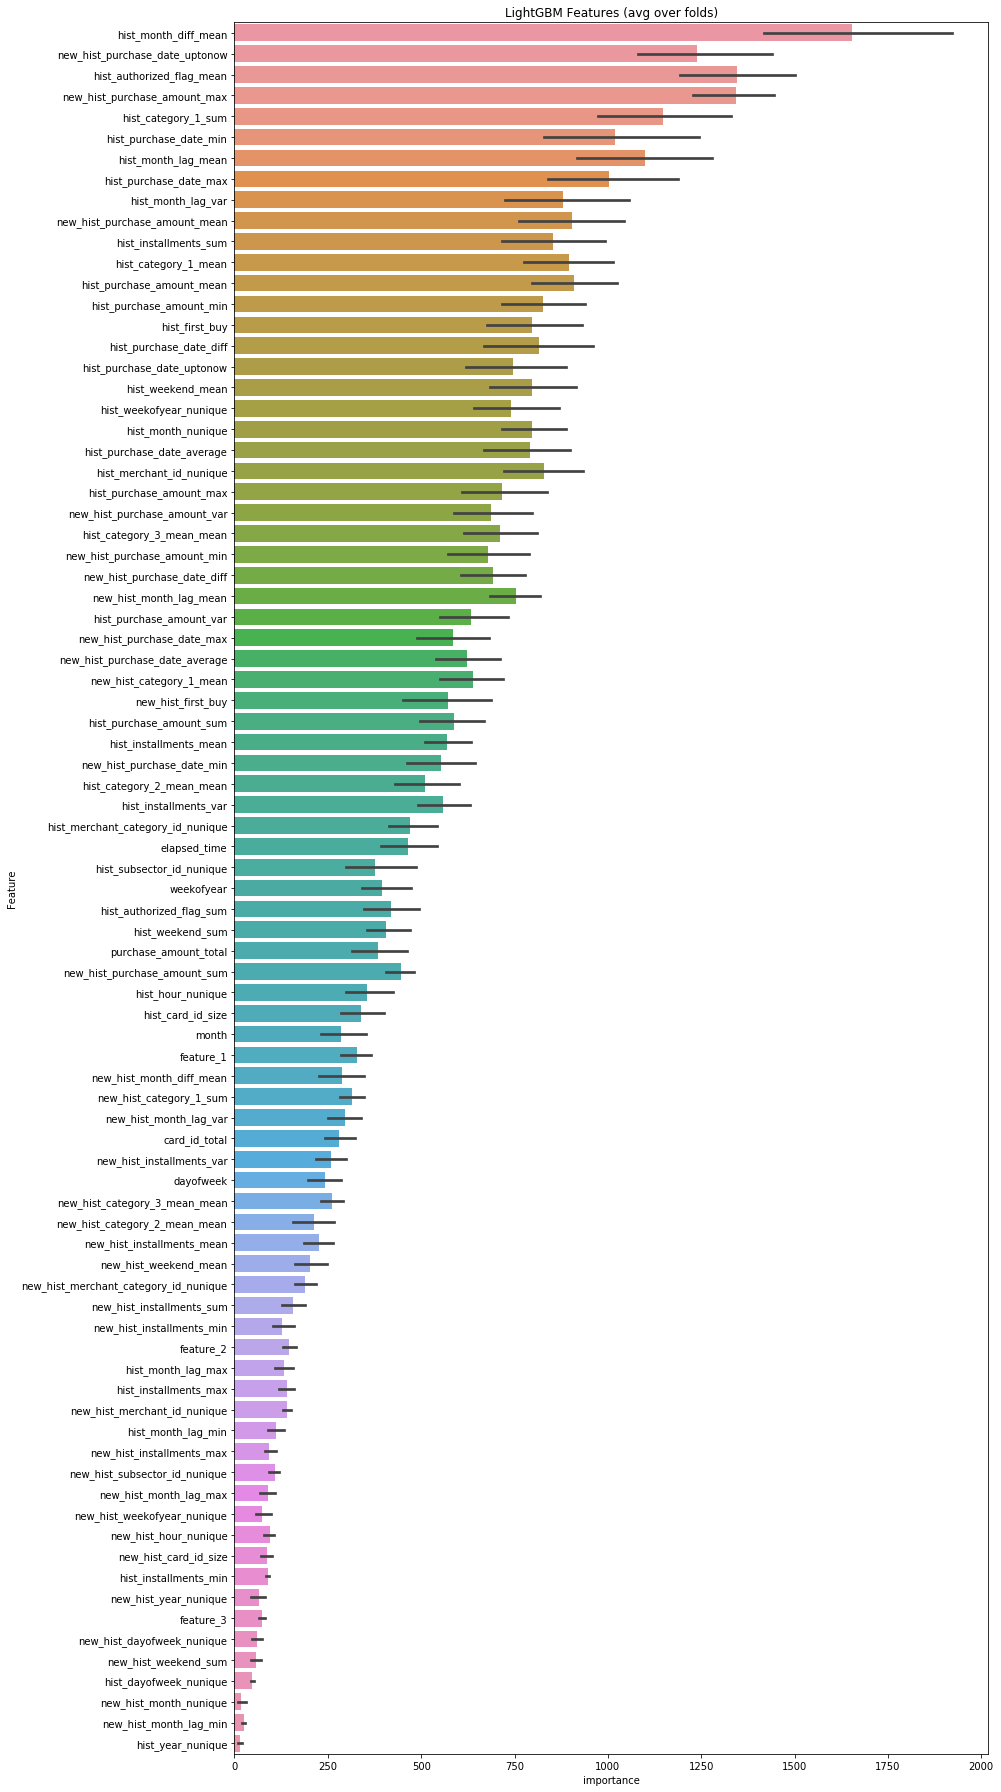

In [34]:
# %%time
now_time = processtime("lightbgm feature start",pretime)
pretime = now_time

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

now_time = processtime("lightbgm feature end",pretime)
pretime = now_time

In [35]:
# %%time
now_time = processtime("submission start",pretime)
pretime = now_time

sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
suffix = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
sub_df.to_csv("submission_{}.csv".format(suffix), index=False)

now_time = processtime("submission end",pretime)
pretime = now_time

[time] :  submission start
time : 949.2838752269745, one step : 1.85463547706604
[time] :  submission end
time : 949.6344487667084, one step : 0.3505735397338867
